# Interest rates in a Huggett economy with naive hyperbolic discounters

*   Consumers have the utility function
    $$\mathcal{U}(c_t, c_{t+1}, \dots) = U(c_t) + \beta \mathrm{E}_t \sum_{s=0}^\infty \delta^s U(c_{t+s})$$
*   Consumers believe that in the future they will have the utility function
    $$\mathcal{U}(c_t, c_{t+1}, \dots) = U(c_t) + \hat\beta\mathrm{E}_t\sum_{s=0}^\infty \delta^s U(c_{t+s})$$
*   Consumers have an endowment in each period following a Markov-process
    $$ y_t \sim F(y_t|y_{t-1}) $$
*   Consumers have access to a riskless bond with borrowing limit $\underline{a}$ paying interest rate $r$

## Imports from the main file

In [9]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from concurrent.futures import ProcessPoolExecutor

from huggett import (get_policy_functions,
                     excess_asset_demand,
                     get_excess_asset_demand,
                     get_eq_r,
                     get_eq_rl,
                     paramfun,
                     paramfun2,
                     SHOCKS
                     )

import seaborn as sns

## Constants

In [2]:
PARAMS = [[{'beta': beta,
            'betahat': betahat,
            'delta': 0.99,
            'gamma': 3,
            'Pi': np.array([[0.5, 0.075], [0.5, 0.925]]),
            'aBar': -2,
            'e': np.array([0.1, 1])
           }
           for betahat in np.arange(beta, 1.0001, 0.025)
          ]
          for beta in [0.6, 0.7, 0.8, 0.9, 1]
         ]

# Results

## Example consumption functions

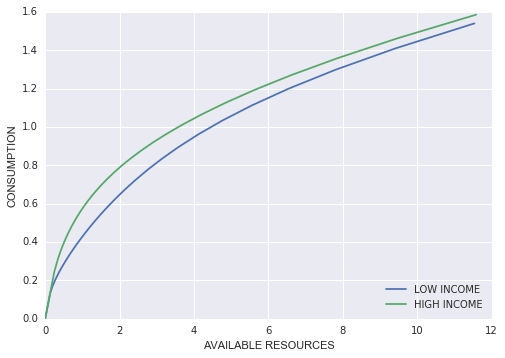

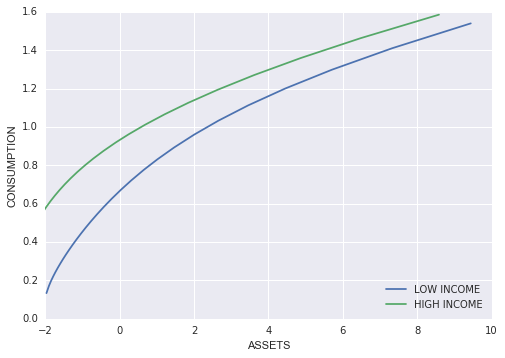

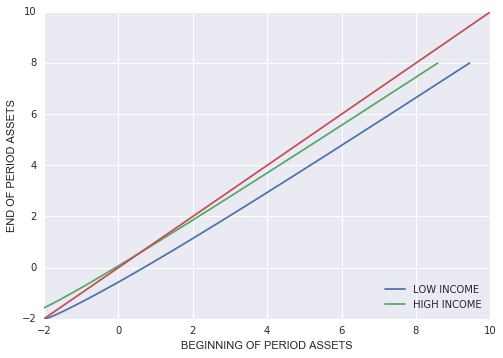

In [10]:
GRIDS = get_policy_functions(0, 0, PARAMS[2][2])

plt.figure()
plt.plot(np.vstack((np.zeros((1, 2)), GRIDS['m'])),
         np.vstack((np.zeros((1, 2)), GRIDS['c']))
         )
plt.xlabel('AVAILABLE RESOURCES')
plt.ylabel('CONSUMPTION')
plt.legend(['LOW INCOME', 'HIGH INCOME'], loc=4)
plt.show()

plt.figure()
plt.plot(GRIDS['s'],
         GRIDS['c']
         )
plt.xlabel('ASSETS')
plt.ylabel('CONSUMPTION')
plt.legend(['LOW INCOME', 'HIGH INCOME'], loc=4)
plt.xlim((-2, 10))
plt.show()

plt.figure()
plt.plot(GRIDS['s'],
         np.transpose(np.tile(GRIDS['a'], (2,1)))
         )
plt.plot([-2, 10], [-2, 10])
plt.xlabel('BEGINNING OF PERIOD ASSETS')
plt.ylabel('END OF PERIOD ASSETS')
plt.legend(['LOW INCOME', 'HIGH INCOME'], loc=4)
plt.xlim((-2, 10))
plt.show()

## Equilibrium interest rates

In [4]:
EQRS = []

for i in range(len(PARAMS)):
    with ProcessPoolExecutor(max_workers=8) as executor:
        RS = []
        for (p, r) in zip(PARAMS[i], executor.map(paramfun, PARAMS[i])):
            RS.append((p['beta'], p['betahat'], r[0]))
    executor.shutdown()
    EQRS.append(pd.DataFrame(RS,  columns=['beta', 'betahat', 'r']))

EQDF = pd.concat(EQRS)
EQDF.columns = ['beta', 'betahat', 'r']

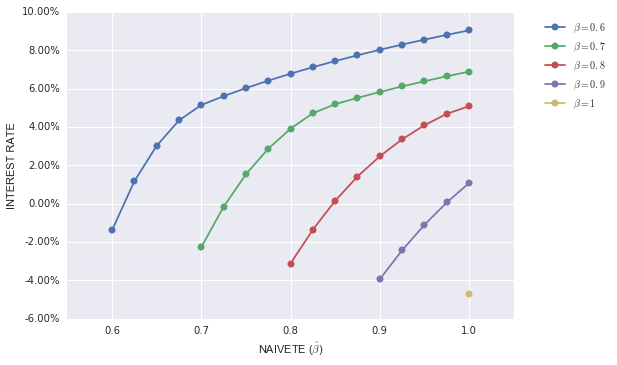

In [11]:
figr, axr = plt.subplots(1,1)
for df in EQRS:
    df.plot(x='betahat', y='r', ax=axr, marker='o')

axr.legend(['$\\beta = 0.6$',
            '$\\beta = 0.7$',
            '$\\beta = 0.8$',
            '$\\beta = 0.9$',
            '$\\beta = 1$'],
           bbox_to_anchor=(1.05, 1),
           loc=2
           )
axr.set_xlabel('NAIVETE ($\\hat\\beta$)')
axr.set_ylabel('INTEREST RATE')
axr.set_xlim([0.55, 1.05])
vals = axr.get_yticks()
axr.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
plt.show()


In [6]:
def paramfilter(par):
    return EQDF[np.logical_and(EQDF['beta'] == par['beta'],
                               EQDF['betahat'] == par['betahat'])
               ].r.iloc[0] > 0.01

PARAMS2 = [list(filter(paramfilter, paramset)) for  paramset in PARAMS]
PARAMS2 = [p for p in PARAMS2 if p != []]

In [7]:
EQRLS = []

for i in range(len(PARAMS2)):
    with ProcessPoolExecutor(max_workers=8) as executor:
        RS = []
        for (p, rl) in zip(PARAMS2[i], executor.map(paramfun2, PARAMS2[i])):
            RS.append((p['beta'], p['betahat'], rl[0]))
    executor.shutdown()
    EQRLS.append(pd.DataFrame(RS, columns=['beta', 'betahat', 'rl']))

EQDF_L = pd.concat(EQRLS)
EQDF_L.columns = ['beta', 'betahat', 'rl']

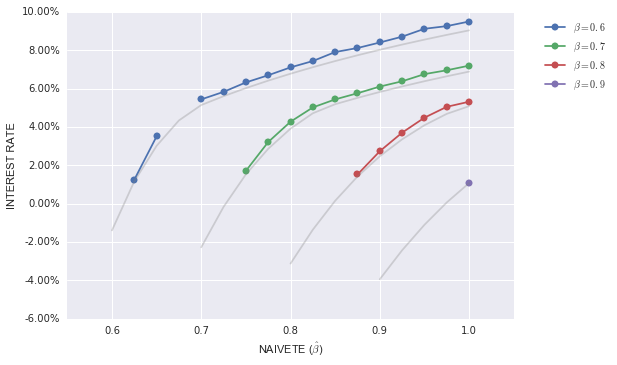

In [21]:
figrl, axrl = plt.subplots(1,1)
for df in EQRLS:
    df.plot(x='betahat', y='rl', ax=axrl, marker='o')
for df in EQRS:
    df.plot(x='betahat', y='r', ax=axrl, alpha=0.3, color='grey')

axrl.legend(['$\\beta = 0.6$',
            '$\\beta = 0.7$',
            '$\\beta = 0.8$',
            '$\\beta = 0.9$',
            '$\\beta = 1$'][0:len(PARAMS2)], 
           bbox_to_anchor=(1.05, 1),
           loc=2
           )
axrl.set_xlabel('NAIVETE ($\\hat\\beta$)')
axrl.set_ylabel('INTEREST RATE')
axrl.set_xlim([0.55, 1.05])
vals = axrl.get_yticks()
axrl.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
plt.show()